# Partie Prophet (données mensuelles)

In [2]:
# Chargement de packages
library(tidyverse)
library(lubridate)
library(readr)
library(ggplot2)
library(readxl)
library(forecast)
library(gridExtra)
library(dplyr)
library(tseries)
library("stats")
library("tidyr")
library("ggplot2")

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"le package 'forecast' a été compilé avec la version R 4.3.2"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attachement du package : 'gridExtra'


L'objet suivant est masqué depuis 'package:dplyr':

    combine




In [3]:
## Chargement des données
donnees_mensuelles = read.csv("mensuelle.csv")

In [4]:
donnees_mensuelles$mois_annee = as.Date(donnees_mensuelles$mois_annee)

In [5]:
head(donnees_mensuelles,5)

mois annee nombre_employes_entree nombre_employes_sortie
1  6   2014  1                      0                     
2  7   2014  2                      0                     
3  8   2014  1                      0                     
4  9   2014  1                      0                     
5 10   2014  1                      0                     
  nombre_employes_total mois_annee
1 1                     2014-06-01
2 3                     2014-07-01
3 4                     2014-08-01
4 5                     2014-09-01
5 6                     2014-10-01

In [6]:
donnees_mensuelles$nombre_employes_total  %>% unique()

[1]   1   3   4   5   6   8  14  17  16  18  19  21  22  25  28  35  38  37  40
[20]  43  46  51  52  57  58  63  69  75  78  79  84  87  85  86  83  88  97 102
[39] 111 122 130 132 142 146 151 153 156 158 159 154 160 163 162 155 150 144 141
[58] 138 139 140 143 157 169 173 175 177 176 179 181 185 186 191 194 197 198 201
[77] 206 208 203 200

Prophet peut être utilisé pour ajuster des données mensuelles. Cependant, d'après sa documentation, le modèle sous-jacent est en temps continu, ce qui signifie que l'on pourrait obtenir des résultats étranges si nous ajustons le modèle aux données mensuelles et demandez ensuite des prévisions quotidiennes.

## Modèle par défaut

In [7]:
library(prophet)

Warning message:
"le package 'prophet' a été compilé avec la version R 4.3.2"
Le chargement a nécessité le package : Rcpp

Le chargement a nécessité le package : rlang


Attachement du package : 'rlang'


Les objets suivants sont masqués depuis 'package:purrr':

    %@%, flatten, flatten_chr, flatten_dbl, flatten_int, flatten_lgl,
    flatten_raw, invoke, splice




In [8]:
## données
donnees = donnees_mensuelles[,c("mois_annee","nombre_employes_total")]

In [9]:
colnames(donnees) <- c("ds", "y")

### Split des données

In [10]:
length = round(nrow(donnees)*0.8)
length

[1] 92

In [11]:
data_train = donnees[1:length,]
data_test = donnees[(length+1):nrow(donnees),]

In [12]:
nrow(data_train)

[1] 92

In [13]:
nrow(data_test)

[1] 23

### Définition du modèle

In [21]:
m_default = prophet(data_train, interval.width = 0.95)

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



In [22]:
m_default %>% head(5)

$growth
[1] "linear"

$changepoints
 [1] "2014-09-01 GMT" "2014-12-01 GMT" "2015-03-01 GMT" "2015-06-01 GMT"
 [5] "2015-08-01 GMT" "2015-11-01 GMT" "2016-02-01 GMT" "2016-05-01 GMT"
 [9] "2016-08-01 GMT" "2016-11-01 GMT" "2017-02-01 GMT" "2017-05-01 GMT"
[13] "2017-07-01 GMT" "2017-10-01 GMT" "2018-01-01 GMT" "2018-04-01 GMT"
[17] "2018-07-01 GMT" "2018-10-01 GMT" "2019-01-01 GMT" "2019-04-01 GMT"
[21] "2019-06-01 GMT" "2019-09-01 GMT" "2019-12-01 GMT" "2020-03-01 GMT"
[25] "2020-06-01 GMT"

$n.changepoints
[1] 25

$changepoint.range
[1] 0.8

$yearly.seasonality
[1] "auto"


Par défaut, Prophet choisit comme valeur des hyperparamètres : 
- **growth** : "linear" ;
- **n.changepoints** : 25 ;
- **changepoint.range** : 0.8 ;
- **yearly.seasonality** : "auto"

## Sans holidays ni events 

In [23]:
future = m_default %>% make_future_dataframe(freq = "month", periods = nrow(data_test))
forecast = m_default %>% predict(future)

In [24]:
forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')] %>% head(7)

ds         yhat       yhat_lower yhat_upper
1 2014-06-01 -8.8517806 -28.90399  11.29579  
2 2014-07-01 -6.7678676 -26.57844  13.40285  
3 2014-08-01 -4.7783108 -24.29327  14.43593  
4 2014-09-01 -2.2782327 -21.67797  16.86147  
5 2014-10-01 -1.7241326 -20.10736  19.23737  
6 2014-11-01  0.9323012 -18.04374  21.16592  
7 2014-12-01  4.4130270 -14.48794  23.73808

In [25]:
options(repr.plot.width=20, repr.plot.height=10)

ggplot() +
  geom_line(data = data_train, aes(x = as.Date(ds), y = y, group = 1, color = "Données d'entraînement"), linewidth = 1) +
  geom_line(data = data_test, aes(x = as.Date(ds), y = y, group = 1, color = "Données de test"), linewidth = 1.5) +
  labs(title = "Prévisions vs Réalité", x = "Date", y = "Valeur") +
  scale_color_manual(values = c("Données d'entraînement" = "blue", "Données de test" = "red")) +
  theme_minimal(base_size = 25) +
  theme(legend.position = "right",
        axis.text.x = element_text(angle = 90, hjust = 1))

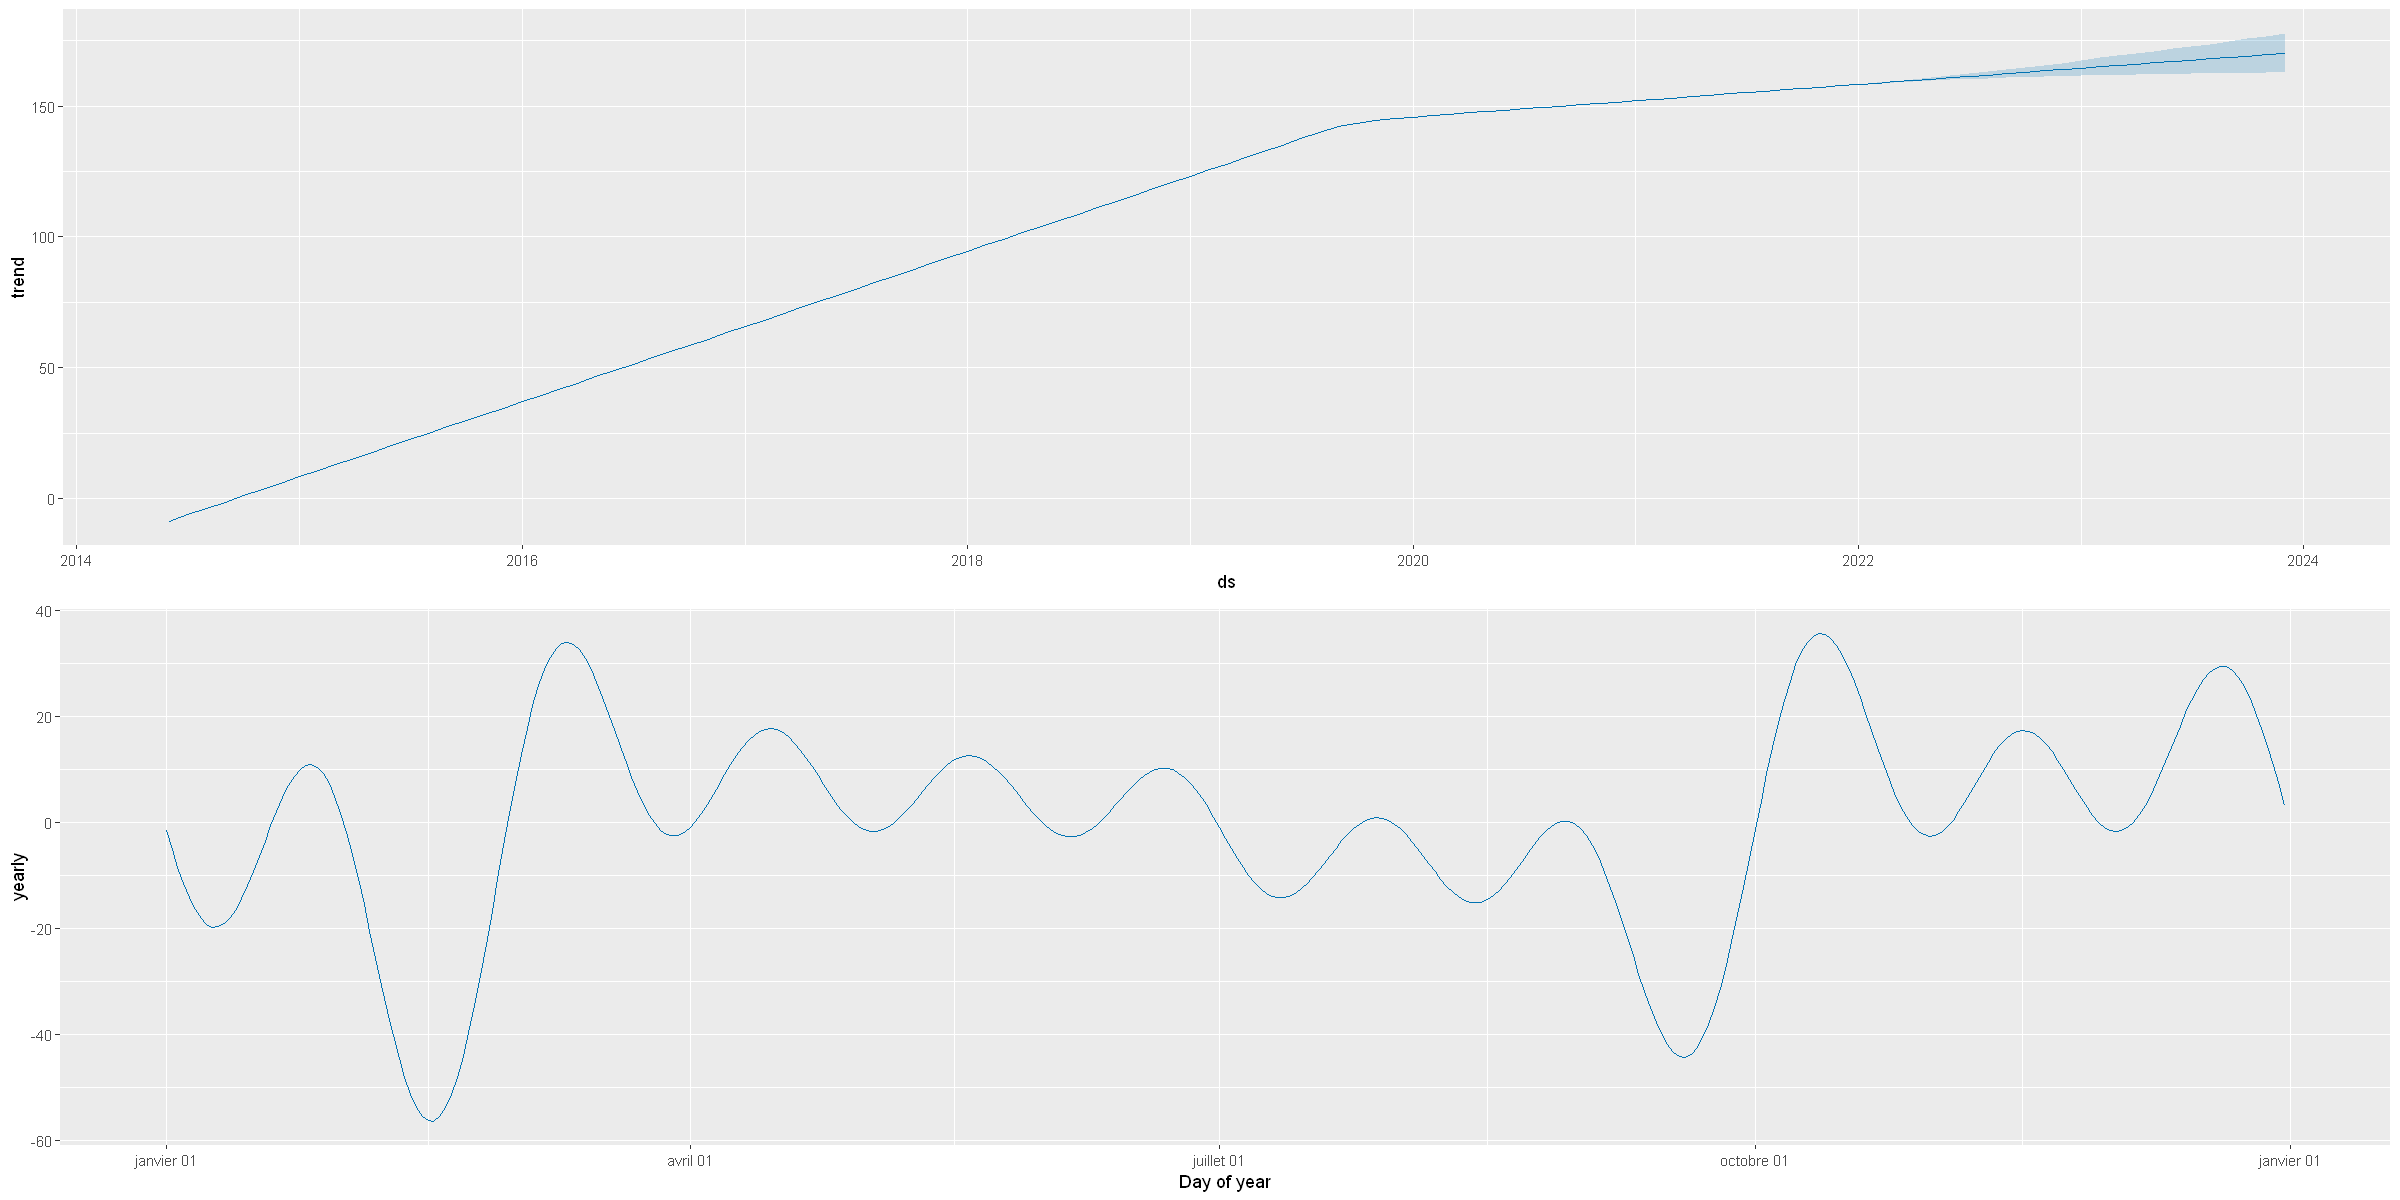

In [17]:
# Spécification de la taille du graphique
options(repr.plot.width=20, repr.plot.height=10)

prophet_plot_components(m_default, forecast)

In [34]:
# Spécification de la taille du graphique
options(repr.plot.width=20, repr.plot.height=10)
donnees$ds <- as.Date(donnees$ds)
forecast$ds <- as.Date(forecast$ds)
ggplot() +
  geom_line(data = donnees, aes(x = ds, y = y, group = 1, color = "Données mensuelles"), linewidth = 2.5) +
  geom_line(data = forecast, aes(x = ds, y = yhat, color = "Prédictions du modèle"), size = 1.5) +
  geom_ribbon(data = forecast, aes(x = ds, ymin = yhat_lower, ymax = yhat_upper), fill = "lightblue", alpha = 0.5) +
  labs(title = "Prévisions",
       x = "Date",
       y = "Valeurs prévues pour les données simulées") +
  theme_minimal(base_size = 25)

### Calcul du mape et du rmse 

In [56]:
mean_absolute_percentage_error <- function(y_true, y_pred) {
  y_true <- as.numeric(y_true)
  y_pred <- as.numeric(y_pred)
  mean(abs((y_true - y_pred) / y_true)) * 100
}

In [20]:
mape = mean_absolute_percentage_error(data_test$y,forecast$yhat)
rmse = sqrt(mean((data_test$y - forecast$yhat)^2))

In [21]:
print(mape)
print(rmse)

[1] 43.13035
[1] 97.10218


Le modèle par défaut présente des indicateurs d'erreur de prédiction qui ont des valeurs très élevées. L'optimisation des hyperparamètres permettra d'avoir une meilleure précision.

### Que se passe t-il si l'on ajoute les holidays et les events ?

D'après la $\href{https://facebook.github.io/prophet/docs/non-daily_data.html#monthly-data}{documentation}$ de prophet, les effets des jours fériés sont appliqués à la date particulière à laquelle le jour férié a été spécifié. Avec des données agrégées selon une fréquence hebdomadaire ou mensuelle, les jours fériés qui ne correspondent pas à la date particulière utilisée dans les données seront ignorés : par exemple, un lundi férié dans une série chronologique hebdomadaire où chaque point de données correspond à un dimanche. Pour inclure les effets des vacances dans le modèle, les vacances devront être déplacées vers la date de la base de données historique pour laquelle l'effet est souhaité. Notez qu'avec des données agrégées hebdomadaires ou mensuelles, de nombreux effets des vacances seront bien capturés par la saisonnalité annuelle, de sorte que l'ajout de vacances peut être nécessaire uniquement pour les vacances qui surviennent au cours de différentes semaines tout au long de la série chronologique.

In [36]:
jours_feries <- read.csv("jours_feries_france.csv", sep = ";", header = TRUE, fileEncoding = "ISO-8859-1")

In [37]:
jours_feries %>% head(5)

Date       Année Jour.de.la.semaine Statut Code.du.jour Description        
1 01/01/2010 2010  vendredi           férié  5            Jour de l'an       
2 05/04/2010 2010  lundi              férié  1            Lundi de Pâques    
3 01/05/2010 2010  samedi             férié  6            Fête du Travail    
4 08/05/2010 2010  samedi             férié  6            Fête de la Victoire
5 13/05/2010 2010  jeudi              férié  4            Ascension          
  Jour.et.date
1 vendredi 1  
2 lundi 5     
3 samedi 1    
4 samedi 8    
5 jeudi 13

In [38]:
jours_feries <- jours_feries %>%
  mutate(Date = dmy(Date)) %>%
rename(date =`Date`, annee = `Année`, jour_semaine = `Jour.de.la.semaine`, status=`Statut`,
      code_jour = "Code.du.jour", description = `Description`, jour_date = `Jour.et.date`)

In [39]:
jours_feries %>% head(5)

date       annee jour_semaine status code_jour description         jour_date 
1 2010-01-01 2010  vendredi     férié  5         Jour de l'an        vendredi 1
2 2010-04-05 2010  lundi        férié  1         Lundi de Pâques     lundi 5   
3 2010-05-01 2010  samedi       férié  6         Fête du Travail     samedi 1  
4 2010-05-08 2010  samedi       férié  6         Fête de la Victoire samedi 8  
5 2010-05-13 2010  jeudi        férié  4         Ascension           jeudi 13

In [40]:
holidays = jours_feries %>% 
                filter((date >= min(data_train$ds)) & date <= max(data_train$ds)) %>% 
                select( c(date,description,jour_date)) %>% 
                rename(ds = `date`) %>%
                mutate(lower_window = 0, upper_window = 1)

In [41]:
holidays$description <- iconv(holidays$description, to = "UTF-8", sub = "byte")

holidays$description <- gsub("[^a-zA-Z0-9]", "", holidays$description)

holidays$description <- tolower(holidays$description)

In [42]:
holidays <- holidays %>% rename(holiday = description)

In [43]:
holidays = holidays %>% select(c(holiday,ds,lower_window,upper_window))

In [44]:
holidays %>% head(5)

holiday         ds         lower_window upper_window
1 lundidepentecte 2014-06-09 0            1           
2 ftenationale    2014-07-14 0            1           
3 assomption      2014-08-15 0            1           
4 toussaint       2014-11-01 0            1           
5 armistice1918   2014-11-11 0            1

#### Inclusion de l'effet du covid-19

En 2020 et 2021, la France a imposé trois périodes de confinement pour contenir la propagation du Covid-19 : du 17 mars au 11 mai 2020, du 30 octobre au 15 décembre 2020, et du 3 avril au 3 mai 2021.

In [45]:
library(dplyr)
library(lubridate)

# Création du DataFrame lockdowns
lockdowns <- data.frame(
  holiday = c('lockdown_1', 'lockdown_2', 'lockdown_3'),
  ds = as.Date(c('2020-03-17', '2020-10-30', '2021-04-03')),
  ds_upper = as.Date(c('2020-05-10', '2020-12-15', '2021-05-03'))
)

# Conversion en format de date si nécessaire
lockdowns$ds <- as.Date(lockdowns$ds)
lockdowns$ds_upper <- as.Date(lockdowns$ds_upper)

# Calcul de la colonne upper_window
lockdowns <- mutate(lockdowns, upper_window = as.numeric(difftime(ds_upper, ds, units = "days")))

lockdowns$lower_window <- 0
lockdowns  = lockdowns %>% select(c(holiday,ds,lower_window,upper_window))

In [46]:
lockdowns

holiday    ds         lower_window upper_window
1 lockdown_1 2020-03-17 0            54          
2 lockdown_2 2020-10-30 0            46          
3 lockdown_3 2021-04-03 0            30

In [47]:
lockdowns <- lockdowns %>% select(c(holiday,ds,lower_window,upper_window))

In [48]:
holidays = rbind(holidays,lockdowns)

In [49]:
holidays %>% tail(5)

holiday    ds         lower_window upper_window
83 nol        2021-12-25 0             1          
84 jourdelan  2022-01-01 0             1          
85 lockdown_1 2020-03-17 0            54          
86 lockdown_2 2020-10-30 0            46          
87 lockdown_3 2021-04-03 0            30

### Déplacement des holidays et events au premier des mois

In [50]:
# Réajuster les dates des jours fériés et les fenêtres de temps
adjusted_holidays <- holidays %>%
  mutate(
    # Ajuster les dates des jours fériés au premier de chaque mois
    ds = floor_date(ds, "month"),
    
    # Calculer le nombre de jours restants dans le mois pour l'effet des jours fériés
    remaining_days = as.numeric(days_in_month(ds) - day(ds) + 1),
    
    # Réajuster les fenêtres de temps
    lower_window = ifelse(upper_window > remaining_days, remaining_days, lower_window),
    upper_window = ifelse(upper_window > remaining_days, upper_window - remaining_days, upper_window)
  ) %>%
  # Regrouper les jours fériés par mois
  group_by(ds) %>%
  summarize(
    holiday = paste(unique(holiday), collapse = ", "),
    lower_window = sum(lower_window),
    upper_window = sum(upper_window)
  )

# Afficher les jours fériés réajustés
print(tail(adjusted_holidays,10))

# A tibble: 10 × 4
   ds         holiday                                  lower_window upper_window
   <date>     <chr>                                           <dbl>        <dbl>
 1 2020-11-01 toussaint, armistice1918                            0            2
 2 2020-12-01 nol                                                 0            1
 3 2021-01-01 jourdelan                                           0            1
 4 2021-04-01 lundidepques, lockdown_3                            0           31
 5 2021-05-01 ftedutravail, ftedelavictoire, ascensio…            0            4
 6 2021-07-01 ftenationale                                        0            1
 7 2021-08-01 assomption                                          0            1
 8 2021-11-01 toussaint, armistice1918                            0            2
 9 2021-12-01 nol                                                 0            1
10 2022-01-01 jourdelan                                           0            1


Les effets ont été déplacés au premier des mois respectifs.

### Estimation du meilleur modèle avec tunning des hyperparamètres

In [37]:
seasonality_mode <- c("multiplicative", "additive")
changepoint_prior_scale <- c(0.1, 0.2, 0.3, 0.4, 0.5)
holidays_prior_scale <- c(0.1, 0.2, 0.3, 0.4, 0.5)
n_changepoints <- c(100, 150, 200)
seasonality_prior_scale <- c(0.01, 0.1, 1.0, 10.0)

param_grid <- expand.grid(#growth = growth,
    seasonality_mode = seasonality_mode,
                           changepoint_prior_scale = changepoint_prior_scale,
                           holidays_prior_scale = holidays_prior_scale,
                           n_changepoints = n_changepoints,
                           seasonality_prior_scale = seasonality_prior_scale#,
#                           weekly_seasonality = TRUE,
#                           daily_seasonality = TRUE,
#                           yearly_seasonality = TRUE)
                          )

# le nombre total de modèles possibles
cat("Total Possible Models:", nrow(param_grid), "\n")

Total Possible Models: 600 


In [38]:
# les premières lignes de la grille de paramètres
head(param_grid)

seasonality_mode changepoint_prior_scale holidays_prior_scale n_changepoints
1 multiplicative   0.1                     0.1                  100           
2 additive         0.1                     0.1                  100           
3 multiplicative   0.2                     0.1                  100           
4 additive         0.2                     0.1                  100           
5 multiplicative   0.3                     0.1                  100           
6 additive         0.3                     0.1                  100           
  seasonality_prior_scale
1 0.01                   
2 0.01                   
3 0.01                   
4 0.01                   
5 0.01                   
6 0.01

In [39]:
# Initialiser une structure de données pour stocker les paramètres et les métriques
model_parameters <- data.frame(MAPE = numeric(), Parameters = character())

# Itérer à travers la grille de paramètres
for (i in 1:nrow(param_grid)) {
  # Récupérer les paramètres pour cette itération
  p <- param_grid[i, ]
  
  # Créer et entraîner le modèle Prophet avec les paramètres spécifiés
m <- prophet(data_train, 
             holidays = holidays,
             #growth = as.character(p$growth),
             changepoint.prior.scale = p$changepoint_prior_scale,
             holidays.prior.scale = p$holidays_prior_scale,
             seasonality.prior.scale = p$seasonality_prior_scale,
             seasonality.mode = p$seasonality_mode,
             weekly.seasonality = FALSE,
             daily.seasonality = FALSE,
             yearly.seasonality = TRUE)
  
   # Générer les prédictions pour les données de test
  forecast <- predict(m, data_test)
  
  # Calculer le MAPE
  MAPE <- mean_absolute_percentage_error(data_test$y, forecast$yhat)
  
  # Afficher le MAPE
  cat("Mean Absolute Percentage Error(MAPE):", MAPE, "\n")
  
  # Ajouter le MAPE et les paramètres à la structure de données
  model_parameters <- rbind(model_parameters, data.frame(MAPE = MAPE, Parameters = paste(p, collapse = ", ")))
}

# Afficher les résultats
print(model_parameters %>% head(5))

Mean Absolute Percentage Error(MAPE): 18.90191 
Mean Absolute Percentage Error(MAPE): 19.43519 
Mean Absolute Percentage Error(MAPE): 13.69 
Mean Absolute Percentage Error(MAPE): 14.70653 
Mean Absolute Percentage Error(MAPE): 12.32183 
Mean Absolute Percentage Error(MAPE): 13.06421 
Mean Absolute Percentage Error(MAPE): 11.43933 
Mean Absolute Percentage Error(MAPE): 12.05766 
Mean Absolute Percentage Error(MAPE): 10.96954 
Mean Absolute Percentage Error(MAPE): 11.72617 
Mean Absolute Percentage Error(MAPE): 18.74186 
Mean Absolute Percentage Error(MAPE): 19.27914 
Mean Absolute Percentage Error(MAPE): 13.51287 
Mean Absolute Percentage Error(MAPE): 14.46349 
Mean Absolute Percentage Error(MAPE): 12.16579 
Mean Absolute Percentage Error(MAPE): 12.90557 
Mean Absolute Percentage Error(MAPE): 11.32142 
Mean Absolute Percentage Error(MAPE): 11.95216 
Mean Absolute Percentage Error(MAPE): 10.85594 
Mean Absolute Percentage Error(MAPE): 11.62512 
Mean Absolute Percentage Error(MAPE): 18.70

In [77]:
# Afficher les résultats
print(model_parameters %>% arrangee(desc(MAPE)) %>% )

ERROR: Error in eval(expr, envir, enclos): objet 'model_parameters' introuvable


In [ ]:
model_parameters[which(model_parameters$MAPE == min(model_parameters$MAPE)),]

MAPE     Parameters          
489 10.48071 1, 0.5, 0.4, 100, 10
539 10.48071 1, 0.5, 0.4, 150, 10
589 10.48071 1, 0.5, 0.4, 200, 10

Dans les détails, il s'agit du modèle avec les paramètres :
- **seasonality_mode** = "multiplicative"
- **changepoint_prior_scale** = 0.5
- **holidays_prior_scale** = 0.1
- **seasonality_prior_scale** = 10

## Modèle final

In [113]:
model_final <- prophet(data_train, 
             holidays = holidays,
             changepoint.prior.scale = 0.5,
             holidays.prior.scale = 0.1,
             seasonality.prior.scale = 10,
             seasonality.mode = "multiplicative",
             n.changepoints = 150,
             weekly.seasonality = FALSE,
             daily.seasonality = FALSE,
             yearly.seasonality = TRUE,
             interval.width=0.95)

n.changepoints greater than number of observations. Using 72



In [114]:
mf_future_dates = model_final %>% make_future_dataframe(freq = "month",periods = nrow(data_test))

In [115]:
mf_forecast = model_final %>% predict(mf_future_dates)

In [116]:
forecast = predict(model_final, data_test)

In [117]:
mean_absolute_percentage_error(data_test$y, forecast$yhat)
sqrt(mean((data_test$y - forecast$yhat)^2))

[1] 11.5805

[1] 23.2278

In [118]:
mf_forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')]%>% tail(10)


ds         yhat     yhat_lower yhat_upper
106 2023-03-01 162.7065 122.36036  199.1010  
107 2023-04-01 160.4545 117.68304  201.0361  
108 2023-05-01 160.4677 113.02462  203.9306  
109 2023-06-01 168.8174 113.51339  218.6429  
110 2023-07-01 170.5484 111.15336  224.5650  
111 2023-08-01 175.0303 111.24590  234.9854  
112 2023-09-01 177.5793 108.09221  243.8016  
113 2023-10-01 171.6388  98.82919  238.7116  
114 2023-11-01 171.6909  93.70610  242.7609  
115 2023-12-01 176.8749  88.81192  256.7576

In [119]:
# Spécification de la taille du graphique
options(repr.plot.width=20, repr.plot.height=20)
prophet_plot_components(model_final, mf_forecast,render_plot = T)

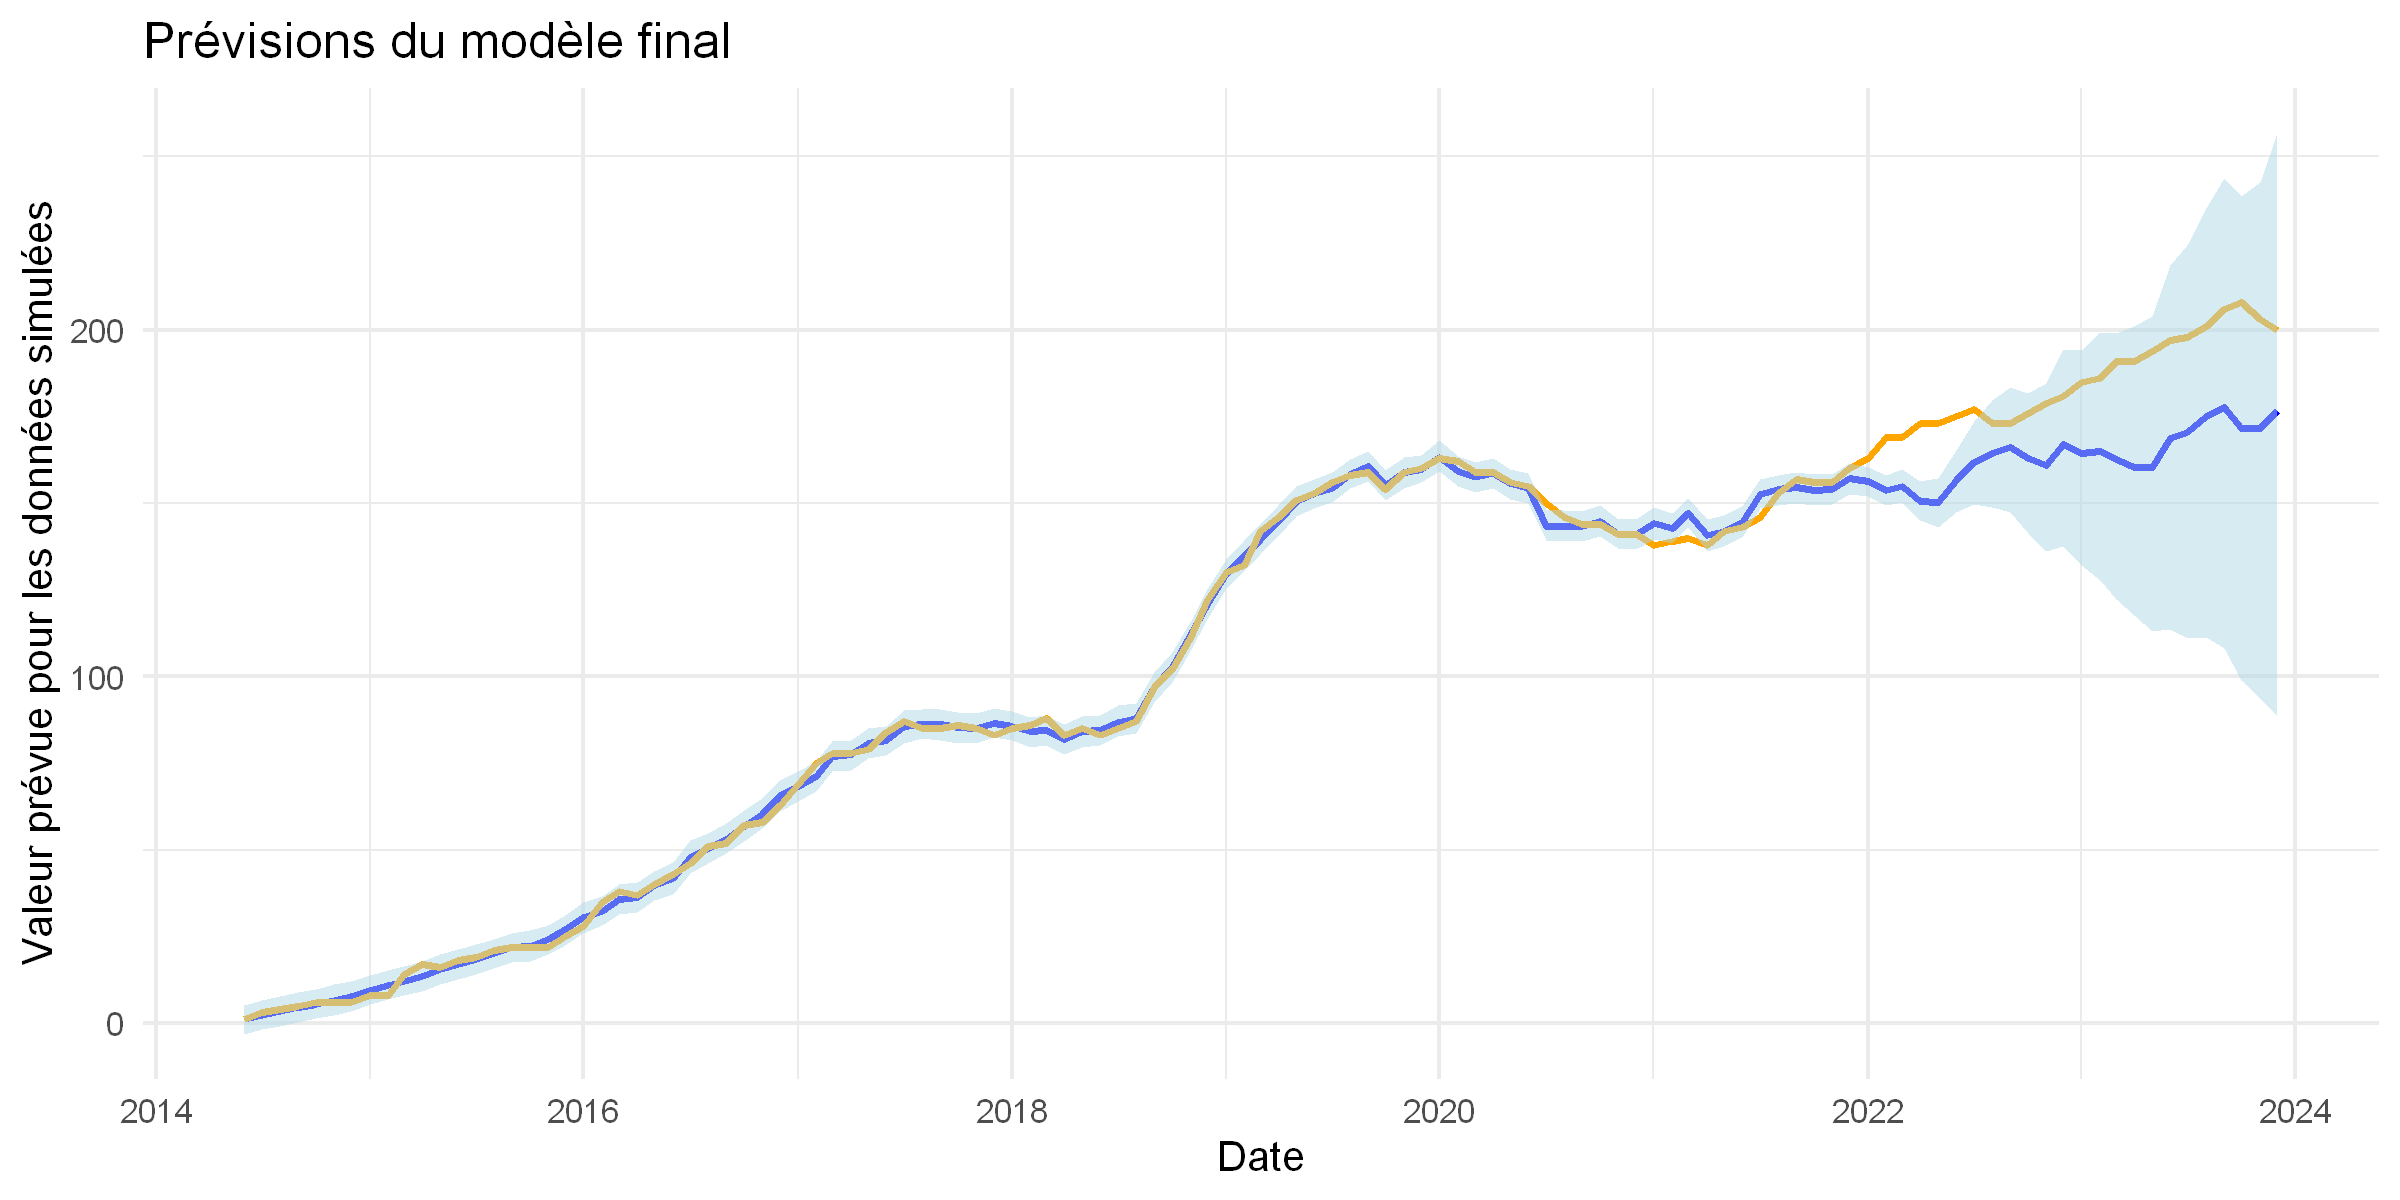

In [120]:
options(repr.plot.width=20, repr.plot.height=10)
# Conversion des dates dans les données de mf_forecast et data
mf_forecast$ds <- as.POSIXct(mf_forecast$ds)
donnees$ds <- as.POSIXct(donnees$ds)

# Tracer les graphiques avec ggplot2
ggplot() +
  geom_line(data = mf_forecast, aes(x = ds, y = yhat), color = "blue", size = 2) +
  geom_line(data = donnees, aes(x = ds, y = y), color = "orange", size = 2) +
  geom_ribbon(data = mf_forecast, aes(x = ds, ymin = yhat_lower, ymax = yhat_upper), fill = "lightblue", alpha = 0.5) +
  labs(title = "Prévisions du modèle final", x = "Date", y = "Valeur prévue pour les données simulées") +
  theme_minimal(base_size = 25)


## Exclusion des holidays

In [108]:
model_final_sans_holidays <- prophet(data_train, 
             #holidays = holidays,
             changepoint.prior.scale = 0.5,
             holidays.prior.scale = 0.1,
             seasonality.prior.scale = 10,
             seasonality.mode = "multiplicative",
             n.changepoints = 150,
             weekly.seasonality = FALSE,
             daily.seasonality = FALSE,
             yearly.seasonality = TRUE,
             interval.width=0.95)

n.changepoints greater than number of observations. Using 72



In [109]:
mf_future_dates = model_final_sans_holidays %>% make_future_dataframe(freq = "month",periods = nrow(data_test))

In [110]:
mf_forecast_without_holidays = model_final_sans_holidays %>% predict(mf_future_dates)

In [111]:
forecast_without_holidays = predict(model_final_sans_holidays, data_test)

In [112]:
mean_absolute_percentage_error(data_test$y, forecast_without_holidays$yhat)
sqrt(mean((data_test$y - forecast_without_holidays$yhat)^2))

[1] 14.56393

[1] 29.14534

In [104]:
mf_forecast_without_holidays[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')]%>% tail(10)

ds         yhat     yhat_lower yhat_upper
106 2023-03-01 159.1120 122.29952  193.9019  
107 2023-04-01 154.8910 115.87721  191.4973  
108 2023-05-01 160.2853 116.60360  202.3589  
109 2023-06-01 160.6412 112.61554  206.4064  
110 2023-07-01 164.5013 112.94626  216.6275  
111 2023-08-01 165.7389 106.63851  219.9180  
112 2023-09-01 166.2806 106.22015  224.1298  
113 2023-10-01 159.3988  96.28961  220.9436  
114 2023-11-01 162.6351  94.32806  229.3316  
115 2023-12-01 164.0640  91.84202  234.9474

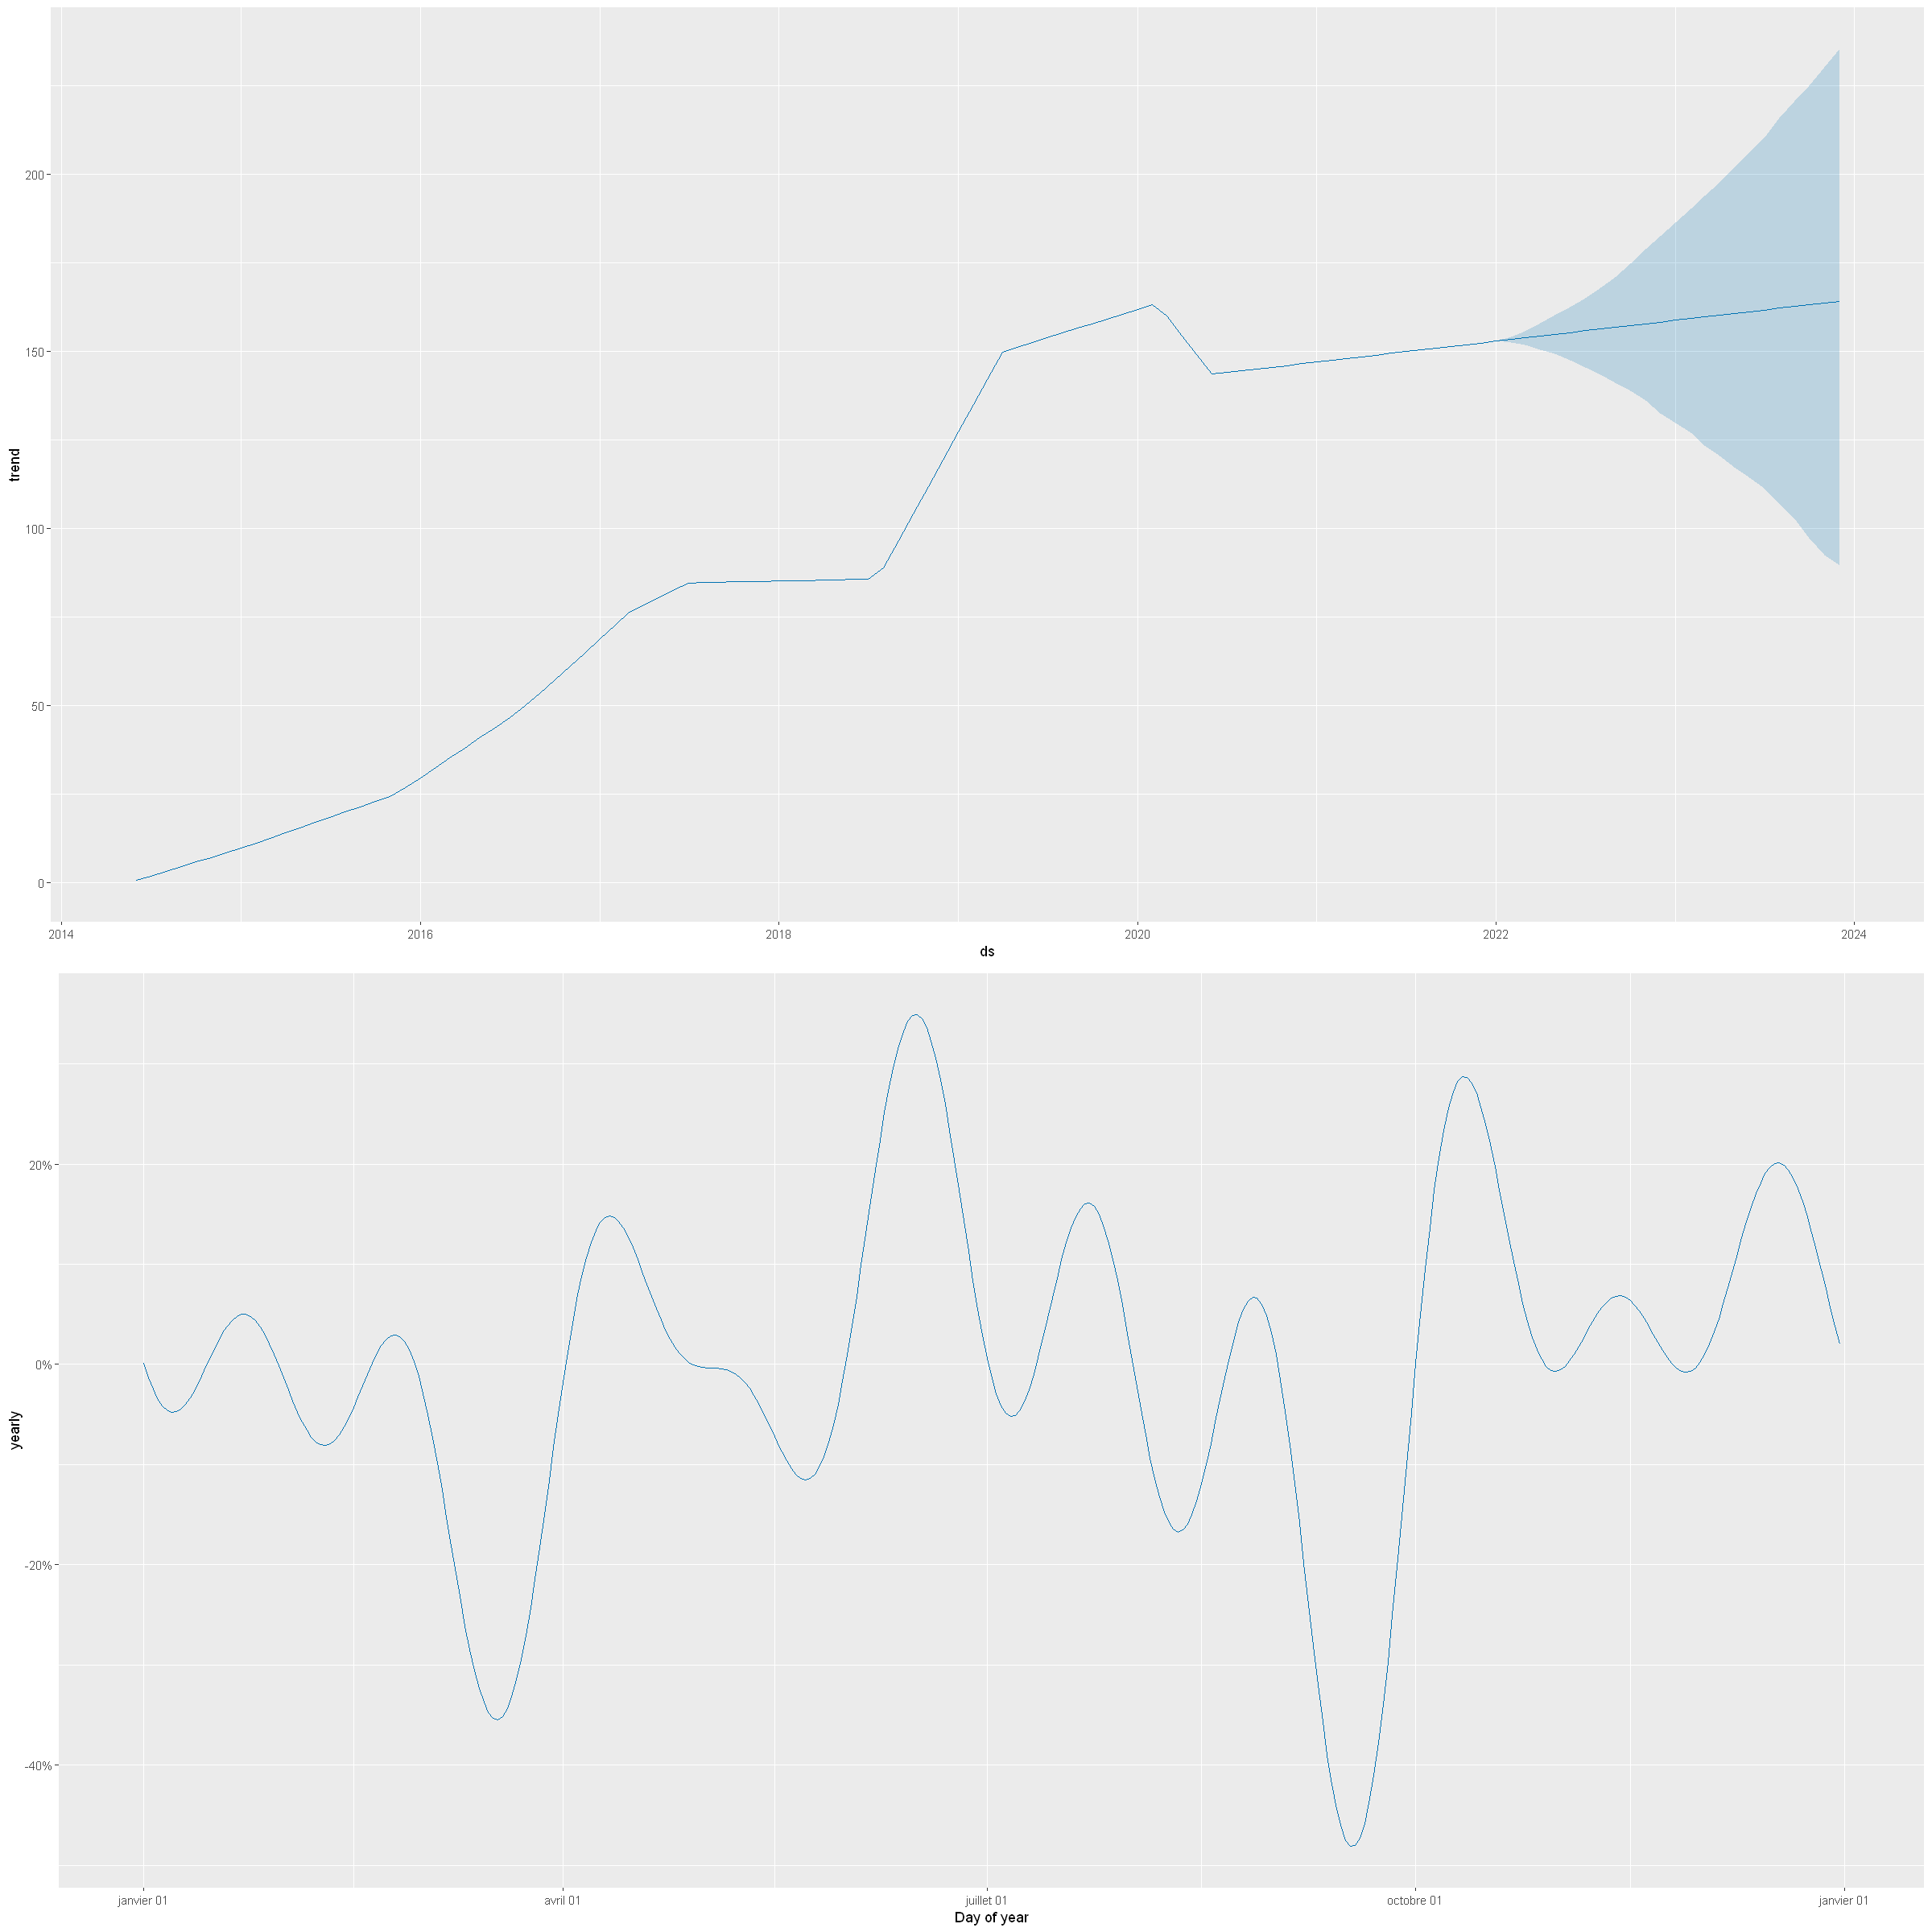

In [105]:
# Spécification de la taille du graphique
options(repr.plot.width=20, repr.plot.height=20)
prophet_plot_components(model_final, mf_forecast_without_holidays,render_plot = T)

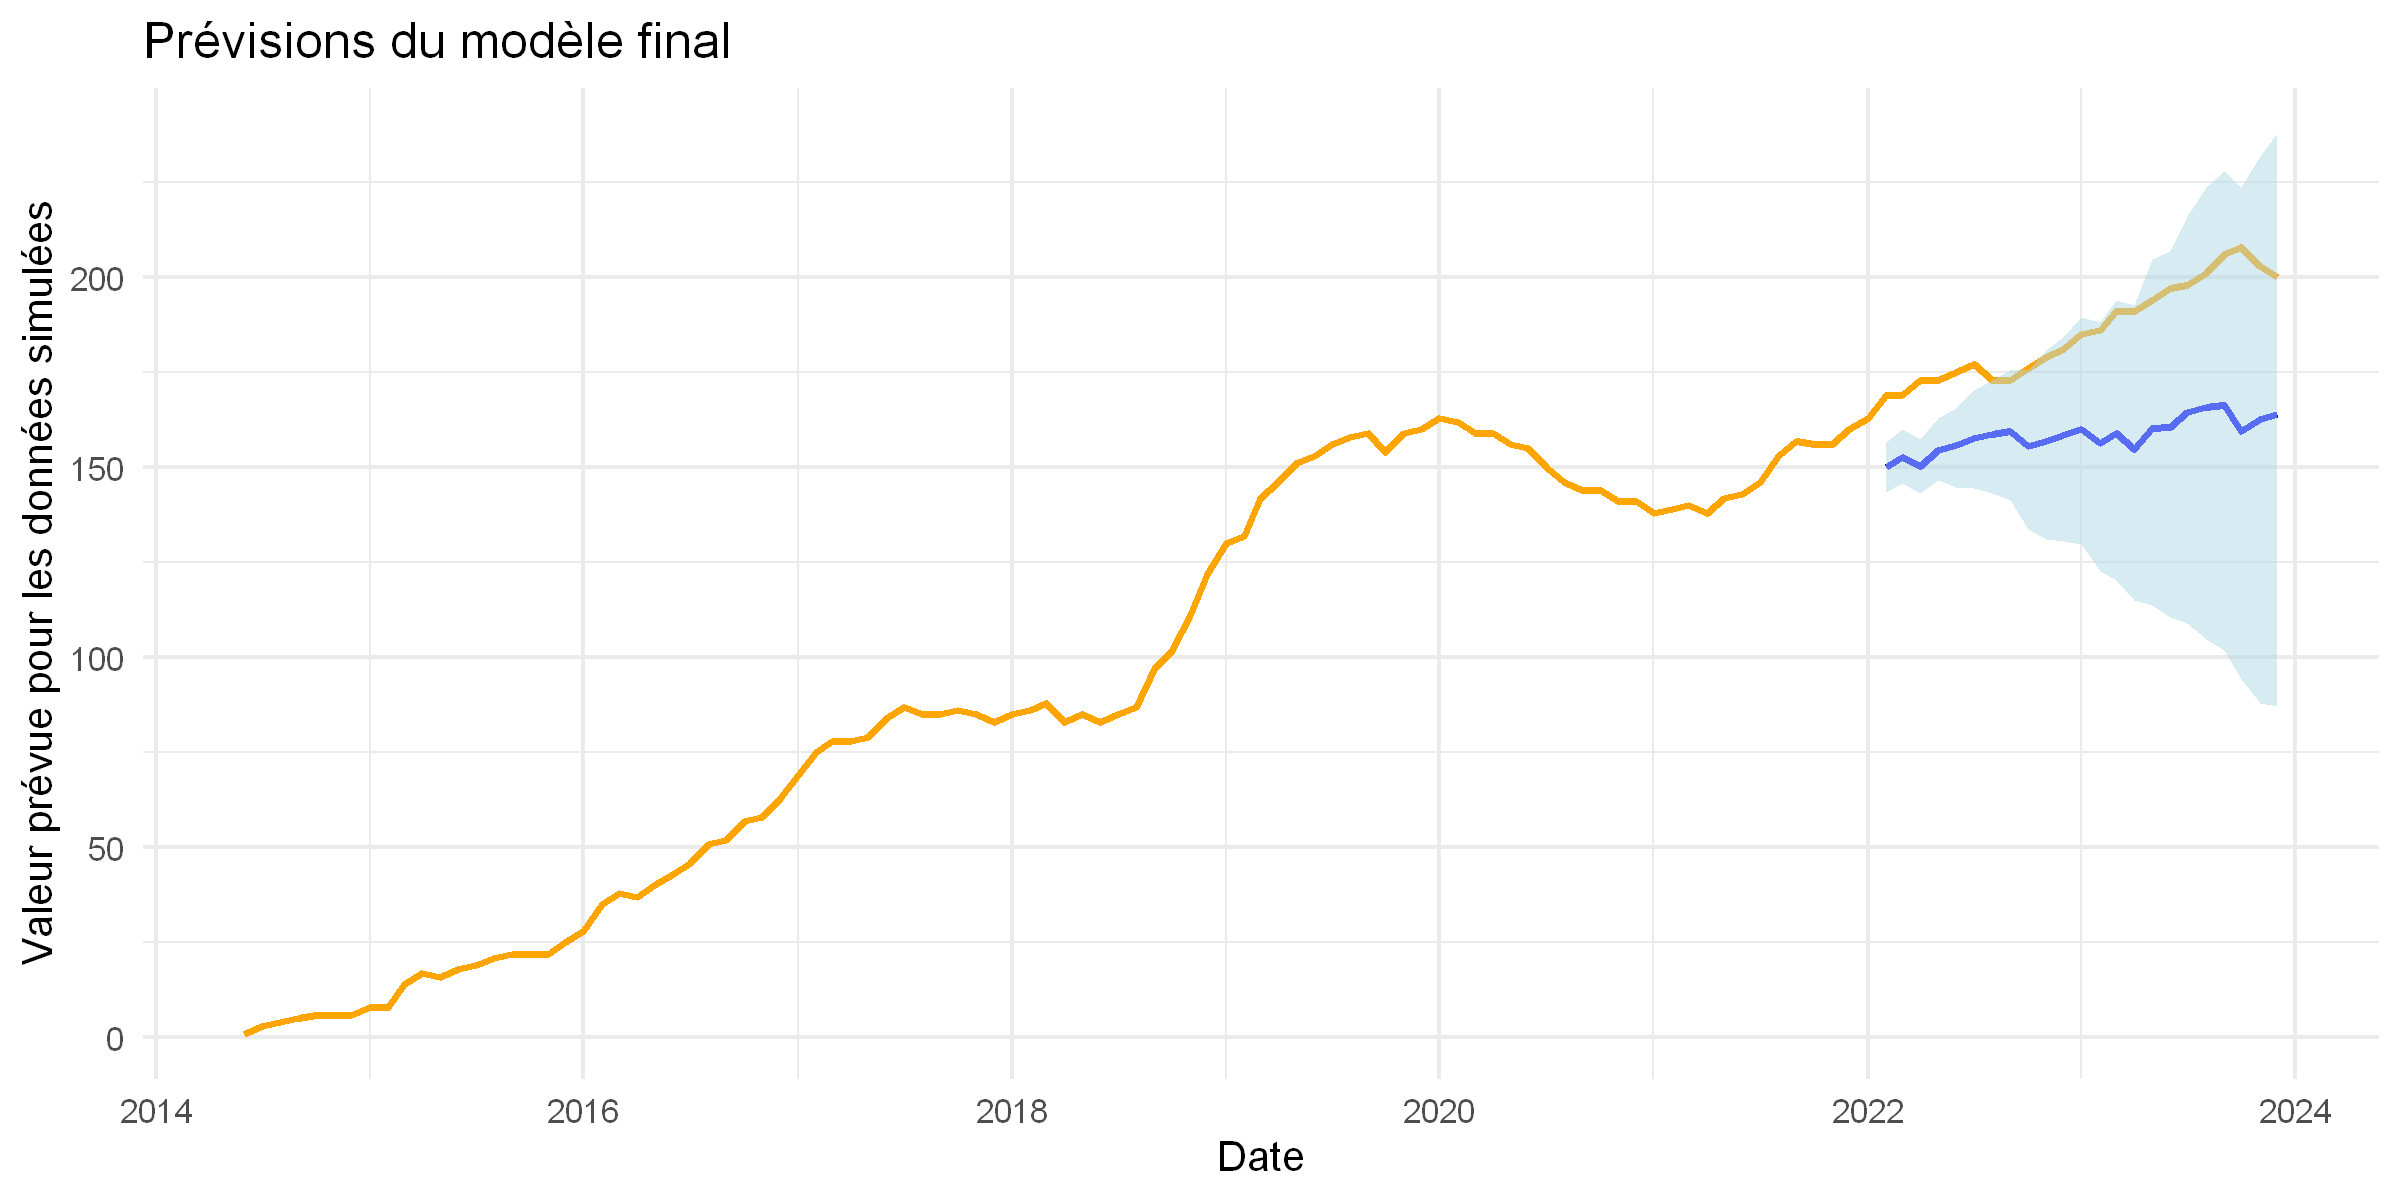

In [106]:
options(repr.plot.width=20, repr.plot.height=10)
# Conversion des dates dans les données de mf_forecast et data
mf_forecast_without_holidays$ds <- as.POSIXct(mf_forecast_without_holidays$ds)
donnees$ds <- as.POSIXct(donnees$ds)

# Tracer les graphiques avec ggplot2
ggplot() +
  geom_line(data = forecast_without_holidays, aes(x = ds, y = yhat), color = "blue", size = 2) +
  geom_line(data = donnees, aes(x = ds, y = y), color = "orange", size = 2) +
  geom_ribbon(data = forecast_without_holidays, aes(x = ds, ymin = yhat_lower, ymax = yhat_upper), fill = "lightblue", alpha = 0.5) +
  labs(title = "Prévisions du modèle final", x = "Date", y = "Valeur prévue pour les données simulées") +
  theme_minimal(base_size = 25)


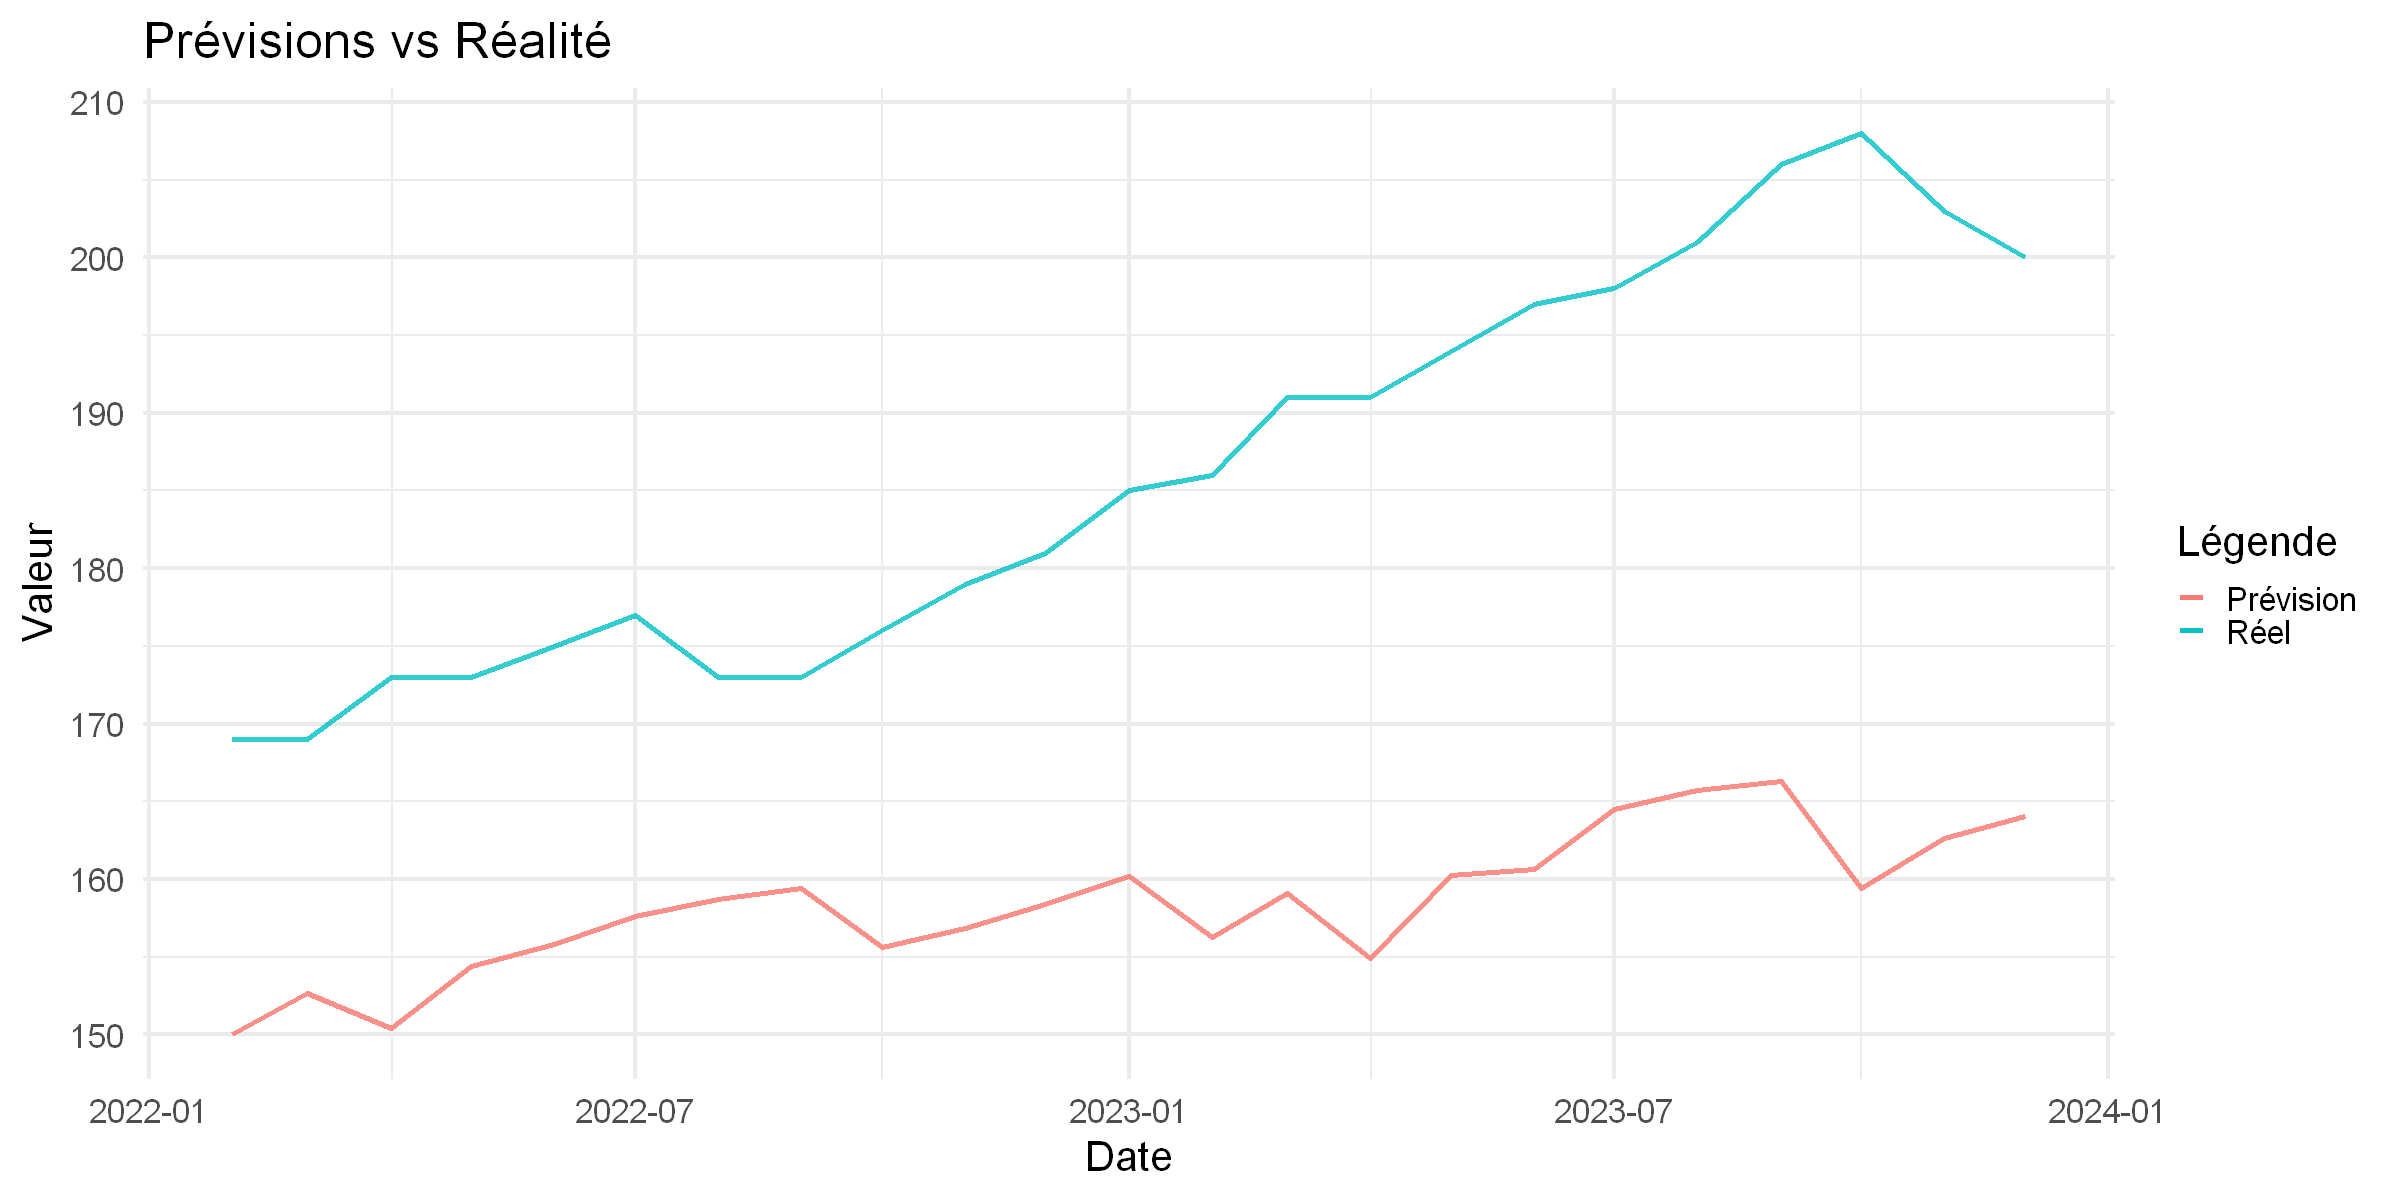

In [107]:
data_test$ds <- as.Date(data_test$ds)
forecast_without_holidays$ds <- as.Date(forecast_without_holidays$ds)


prophet_predict <- ggplot() +
  geom_line(data = data_test, aes(x = ds, y = y, color = "Réel"), linetype = "solid", linewidth = 1.5, alpha = 0.8) +
  geom_line(data = forecast_without_holidays, aes(x = ds, y = yhat, color = "Prévision"), linetype = "solid", linewidth = 1.5, alpha = 0.8) +
  labs(title = "Prévisions vs Réalité", x = "Date", y = "Valeur", color = "Légende") +
  theme_minimal(base_size = 25) +
  theme(legend.position = "right")


print(prophet_predict)

Par constat, l'erreur de prédiction est étroitement lié à la présence ou non des holidays ainsi que du nombre de changepoints. En effet, la présence de holidays et events diminue la précision des prédictions du modèle pour les données mensuelles. Par ailleurs, un modèle avec un nombre faible de changepoints admet une erreur de prédiction plus faible qu'un modèle avec un nombre de changepoints plus élevé. Mais si l'on analyse en terme de représentation graphique, plus le nombre de changepoints est élevé, plus le les ajustements sont bonnes.

Si l'on n'inclut pas les holidays, les prédictions seront plus précis que si l'on les prends en considération dans le cadre des données mensuelles.

## Cross validation

On va présent effectuer une validation croisée.

La validation croisée est une technique très importante qui permet d'évaluer la performance du modèle prophet sur différentes parties de la série temporelle. Cela aide à comprendre comment le modèle se comporte avec différentes périodes de données, à simuler des conditions de prévision en temps réel et à estimer la qualité des prédictions du modèle.

### Importance de la cross validation

De manière générale, l'importance de la validation croisée réside autour de :

- **Évaluation des performances** : La validation croisée permet de mesurer l'erreur de prévision sur des données historiques en simulant des prédictions à différentes périodes de temps.
- **Optimisation des hyperparamètres** : Les résultats de la validation croisée peuvent aider à identifier les meilleures valeurs d'hyperparamètres pour le modèle prophet et à optimiser ses performances.
- **Réduction du surapprentissage** : La validation croisée aide à réduire le risque de surajustement (overfitting) en testant le modèle sur différentes parties de la série temporelle.
- **Prise de décision éclairée** : Les résultats de la validation croisée peuvent être utilisés pour décider si le modèle est prêt pour des prévisions réelles ou s'il nécessite des ajustements.

### Comment se fait la cross validation ?

La validation croisée avec prophet consiste à choisir des points de coupure (cutoffs) dans l'historique de la série. Pour chaque point de coupure, le modèle est entraîné sur les données jusqu'à ce point et testé sur un horizon spécifié (horizon). Les étapes consistent généralement en :
- Sélection des points de coupure : choisir les dates de coupure (cutoffs) dans la série temporelle. Cela détermine où la série est coupée pour chaque itération de validation croisée.
- Entraînement et test : Pour chaque date de coupure, les données avant la date de coupe sont utilisées pour entraîner le modèle, et les données après la date de coupe sont utilisées pour tester les prédictions.
- Calcul des métriques : Les prédictions effectuées sont comparées aux données réelles pour calculer des métriques d'évaluation telles que le MAPE (Mean Absolute Percentage Error) ou d'autres mesures d'erreur.

## Quels sont les paramètres qui sont généralement spécifiés ?

- **initial** : C'est la période d'entraînement initiale. C'est la quantité minimale de données nécessaire pour commencer l'entraînement. Cela établit le contexte historique que Prophet utilise pour créer des prévisions.
- **horizon** : C'est la durée sur laquelle on souhaitez évaluer les prévisions. Cela devrait correspondre à l'horizon de prévision que nous avons l'intention d'utiliser dans le modèle final. Par exemple, si l'on souhaite prévoir un mois dans le futur, notre horizon doit être fixé à 30 jours.
- **period** : C'est la quantité de temps entre chaque pli dans la validation croisée. Cela détermine l'intervalle à partir duquel de nouveaux plis commencent. La période peut être égale, inférieure ou supérieure à l'horizon.
- **cutoffs** : Ce sont les dates auxquelles chaque horizon commencera. Ce sont les points dans le temps où Prophet divisera les données et évaluera le modèle à l'aide de la validation croisée. En spécifiant les cutoffs, on peut contrôler où chaque pli de validation commence dans les données.
- **unit** : unité

### Illustration pour une meilleure compréhension

<div style="width:100%;text-align: center;">
    <img src="img_example_cross_validation.png" style="width:80%;height:100%;" /> <br>
</div>

## Effectuons la validation croisée

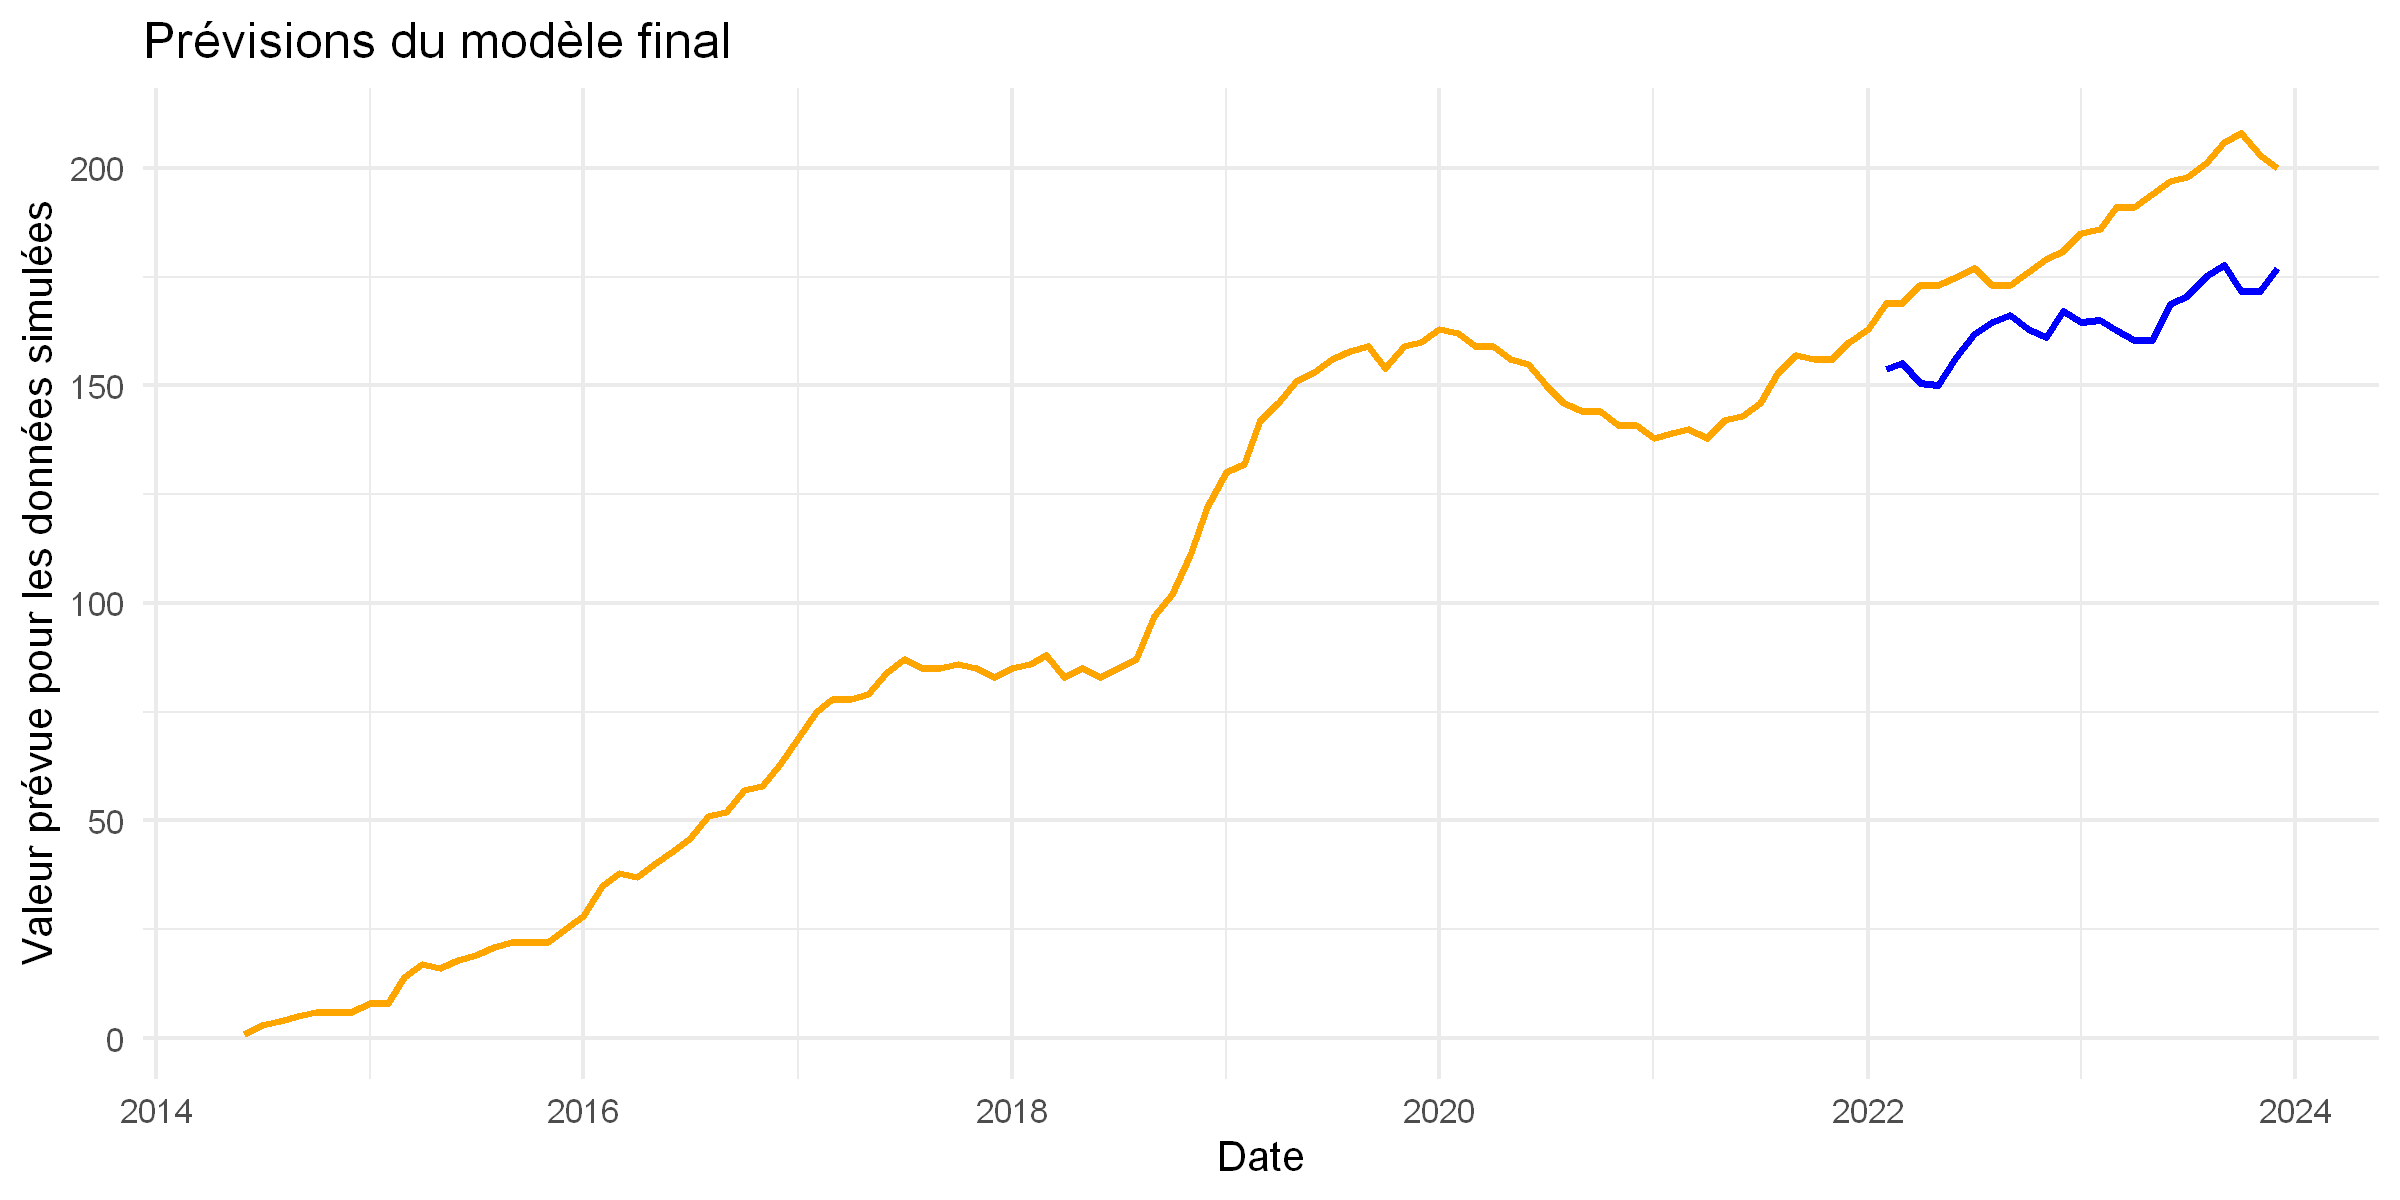

In [121]:
options(repr.plot.width=20, repr.plot.height=10)
# Conversion des dates dans les données de mf_forecast et data
forecast$ds <- as.POSIXct(forecast$ds)
donnees$ds <- as.POSIXct(donnees$ds)

# Tracer les graphiques avec ggplot2
ggplot() +
  geom_line(data = forecast, aes(x = ds, y = yhat), color = "blue", size = 2) +
  geom_line(data = donnees, aes(x = ds, y = y), color = "orange", size = 2) +
  labs(title = "Prévisions du modèle final", x = "Date", y = "Valeur prévue pour les données simulées") +
  theme_minimal(base_size = 25)+
theme(legend.position = "right")

In [122]:
#Valeur des paramètres :
initial <- 12*4
period <- 180  
horizon <- 120
units <- 'days'

In [123]:
#cutoffs <- as.Date(c('2019-12-01', '2020-06-01', '2020-12-01', '2021-06-01', '2022-01-01', '2022-07-01', '2023-01-01'))
df.cv <- cross_validation(model_final, initial = initial, period = period,
                          horizon = horizon, units = units, #cutoffs = cutoffs
                         )
# Calculer les métriques d'évaluation
df.metrics <- performance_metrics(df.cv)
# Afficher les métriques d'évaluation
print(head(df.metrics,5))
print(tail(df.metrics,5))

Making 15 forecasts with cutoffs between 2014-10-10 and 2021-09-03

Warning message in cross_validation(model_final, initial = initial, period = period, :
"Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial."
n.changepoints greater than number of observations. Using 3

n.changepoints greater than number of observations. Using 7

n.changepoints greater than number of observations. Using 12

n.changepoints greater than number of observations. Using 17

n.changepoints greater than number of observations. Using 21

n.changepoints greater than number of observations. Using 26

n.changepoints greater than number of observations. Using 31

n.changepoints greater than number of observations. Using 35

n.changepoints greater than number of observations. Using 40

n.changepoints greater than number of observations. Using 45

n.changepoints greater than number of observations. Using 50

n.changepoints greater than number of observations. Using 5

  horizon        mse      rmse       mae       mape      mdape      smape
1 12 days   37.57161  6.129569  4.307369 0.06544635 0.02522791 0.07123746
2 14 days   60.95692  7.807491  5.111122 0.04413343 0.02522791 0.04585135
3 17 days   75.19459  8.671482  6.095228 0.04448329 0.02522791 0.04543068
4 20 days  134.01399 11.576441  9.118498 0.06118104 0.06294854 0.06107029
5 22 days 3839.57340 61.964291 36.280967 4.59768621 0.10871668 0.46033438
  coverage
1      0.4
2      0.4
3      0.4
4      0.4
5      0.2
    horizon       mse     rmse      mae      mape     mdape     smape coverage
47 114 days 1482.6619 38.50535 37.88207 0.9825673 0.2857420 0.4734234      0.0
48 115 days 1113.9677 33.37615 29.74414 0.9911964 0.3034875 0.4860272      0.2
49 116 days  724.7170 26.92057 23.41602 0.9545074 0.3034875 0.4575852      0.4
50 119 days  396.1772 19.90420 18.45703 1.0122565 0.3869390 0.5731605      0.4
51 120 days  295.8419 17.20006 16.52656 0.2678851 0.1298226 0.3376403      0.4


In [126]:
# Visualiser les résultats de la validation croisée
a = plot_cross_validation_metric(df.cv, metric = 'mape')

In [127]:
# Visualiser les résultats de la validation croisée
b = plot_cross_validation_metric(df.cv, metric = 'rmse')

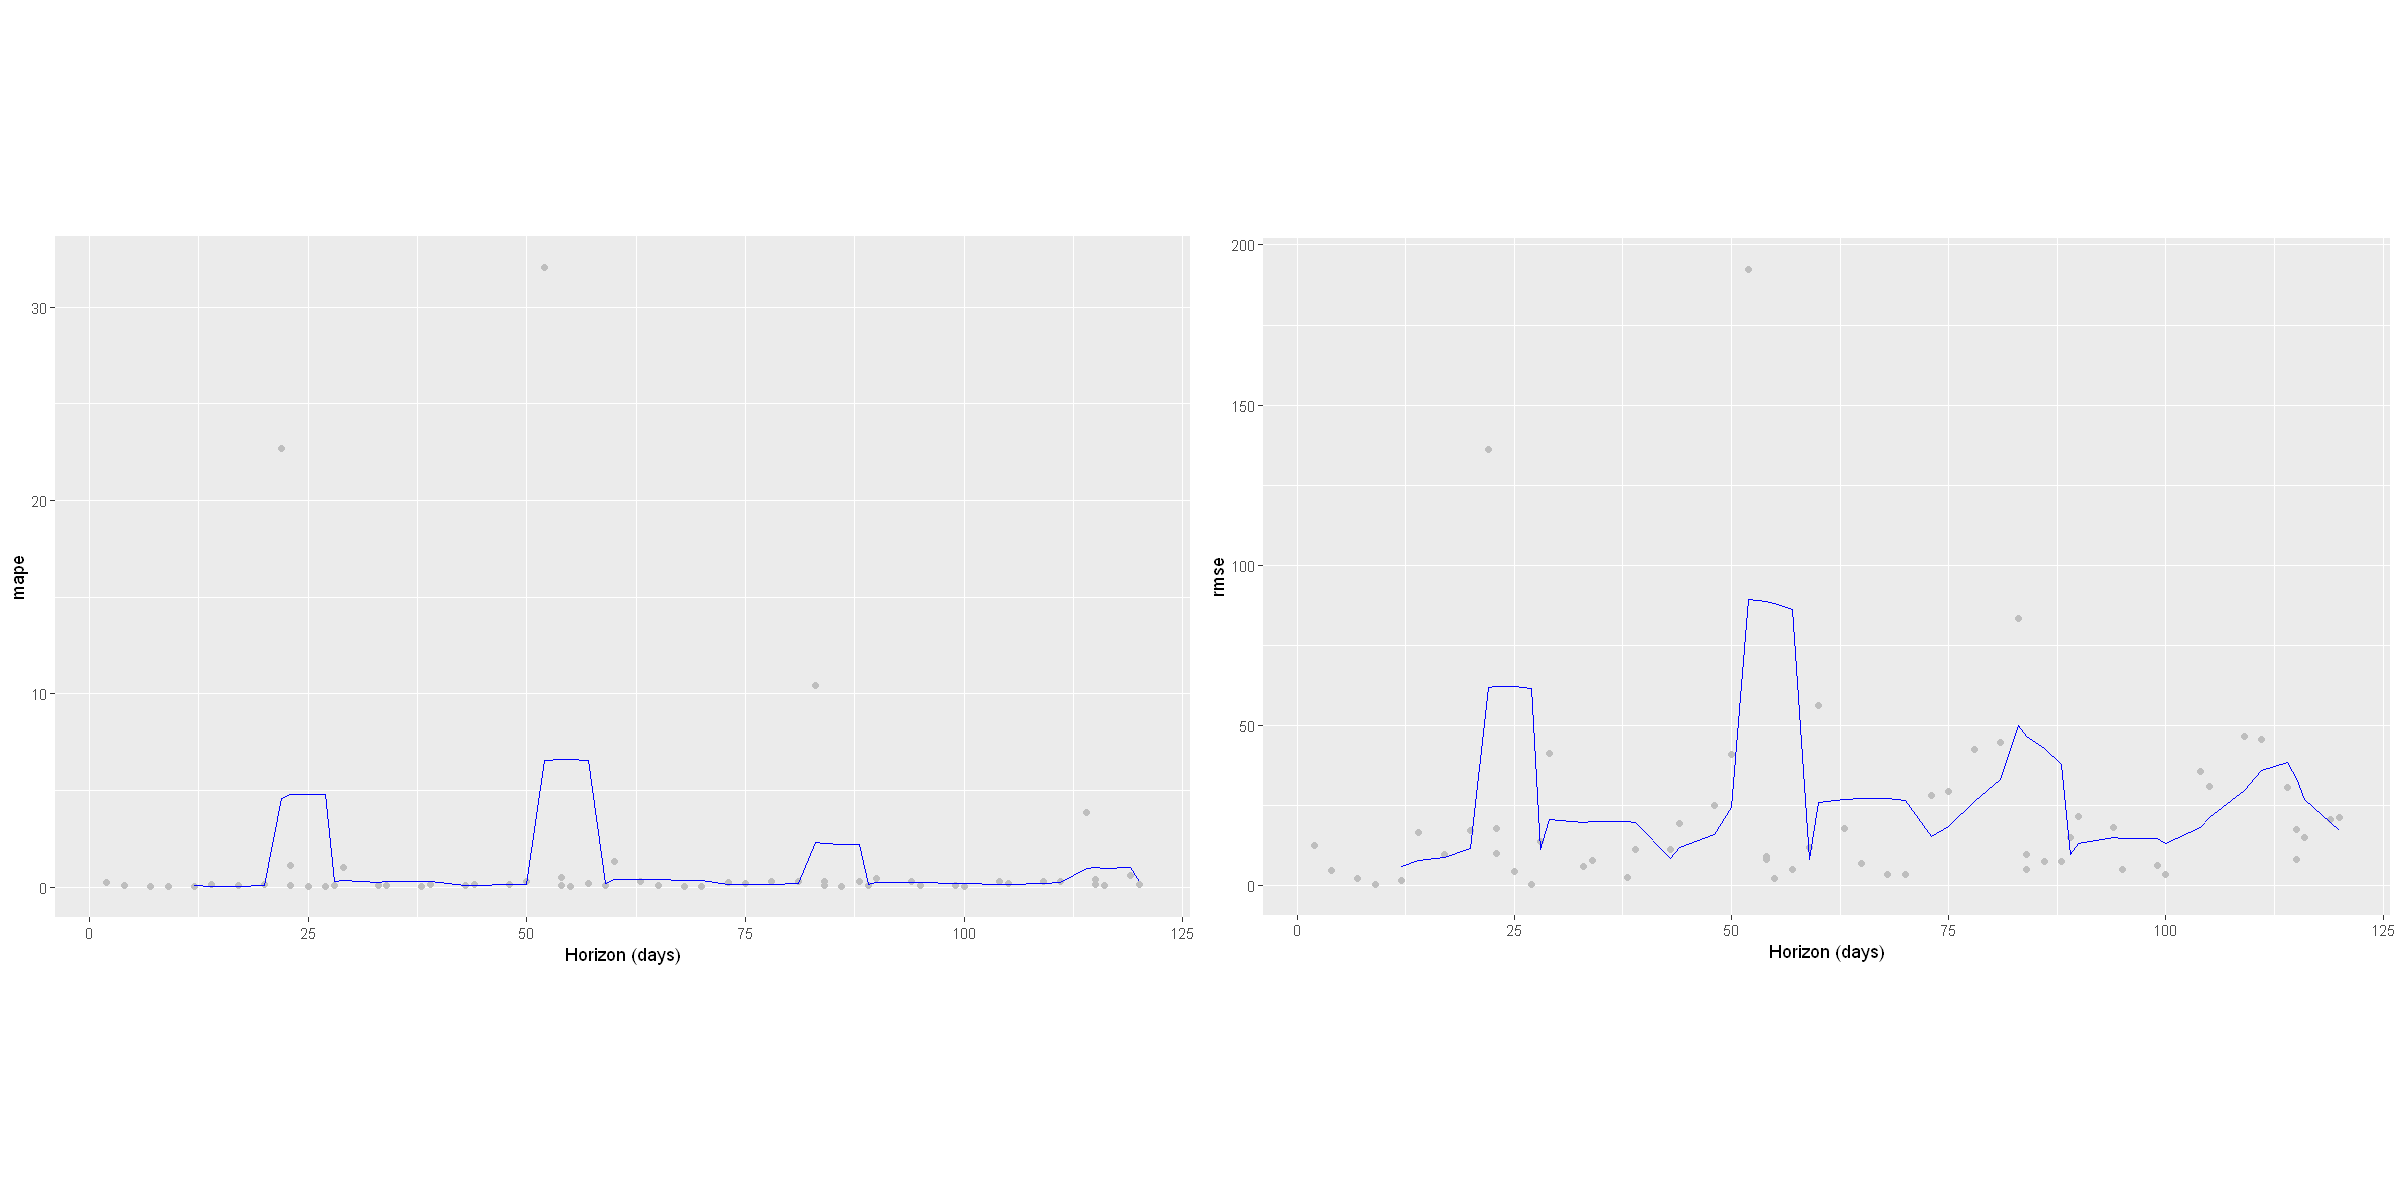

In [128]:
grid.arrange(a,b,ncol=2)

Plus l'horizon est loin, plus le mape est élevé, ce qui pourrait signifier que le modèle est plus performant (plus précis) pour les horizons proches que loin.